# Offshore Oil and Gas Energy System Operation (OOGESO)
# Test platform v1 (Nov 2020)
Representing a hypothetical, but realistic Norwegian offshore oil and gas platform

* wellstream: 50 Sm3/s, of which:
    * gas: 49.75 Sm3/s = 4.3 mill Sm3/day = 4300 Sm3oe/day
    * oil:  0.1 Sm3/s = 8640 Sm3/day  
    * water: 0.15 Sm3/s = 12960 Sm3/day 

Gas oil ratio and water cut (standard units):
* GOR = 4.3 mill/8640 = 497
* WC = 12960/(12960+8640) = 0.6


In [18]:
%load_ext autoreload
%autoreload 2
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)
import oogeso
from oogeso.io import file_io
from oogeso.plotting_utils import plots
#import matplotlib.pyplot as plt
import IPython.display
#import numpy as np
import pandas as pd
import logging
import pprint
import ipywidgets
import cloudpickle
import plotly.express as px
import pyomo.environ as pyo

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('INFO')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read input data

In [42]:
#case='1' # base case without wind
case='1a' # case with 24 MW wind capacity
#case='1b' # case with 24 MW wind capacity AND 4 MW, 4 MWh battery
#timerange=[0,12*24*7] #one week (with 5 min timestep)
timerange=[0,40] # testing
outpath = "result/"
pickle_save='{}case{}.pkl'.format(outpath,case)
plots.plotter="plotly"

data = file_io.read_data_from_yaml('testplatform.yaml')
profiles = file_io.read_profiles_from_xlsx('testplatform_profiles.xlsx')

data['paramParameters']['planning_horizon']=6

for dev in ['Gen1','Gen2','Gen3']:
    data['paramDevice'][dev]['isOn_init'] = 1

if case=='1':
    data['paramDevice']['wind']['Pmax']=0 # no wind
elif case=='1a':
    data['paramDevice']['wind']['Pmax']=8*3 # 3x8 MW, as agreed with ABB
elif case=='1b':
    data['paramDevice']['wind']['Pmax']=8*3 # 3x8 MW, as agreed with ABB
    data['paramDeviceEnergyInitially']['battery'] = data['paramDevice']['battery']['Emax']


# fixed production - not allowed to reduce:
data['paramDevice']['wellL1']['Qmin'] = data['paramDevice']['wellL1']['Qmax']
data['paramDevice']['wellL2']['Qmin'] = data['paramDevice']['wellL2']['Qmax']
# modify reserve requirements:
#data['paramParameters']['elReserveMargin'] = 4 #accept 4MW load loss
#data['paramParameters']['elReserveMargin'] = 0 #accept no load loss (100% backup)
#data['paramParameters']['elReserveMargin'] = -1 #skip constraint
#data['paramParameters']['elBackupMargin'] = 5 #available unused power

optimiser = oogeso.Optimiser(data)
simulator = oogeso.Simulator(optimiser)

INFO:root:profiles in use: ['oilgas', 'waterinj', 'curve_wind']
INFO:root:Using objective function  exportRevenue
INFO:root:No emissionRateMax limit specified
INFO:root:No emissionIntensityMax limit specified
INFO:root:No elBackupMargin limit specified


### Inspect input data

In [5]:
xx=['','paramNode','paramEdge','paramDevice','paramCarriers','paramParameters']
#xx=['']+list(data.keys())
@ipywidgets.interact(datagroup=xx)
def showdata(datagroup):
    pprint.pprint(data[datagroup],width=1) if datagroup!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'paramNode', 'paramEdge', 'paramDevice', …

In [37]:
yy=['']+list(optimiser.pyomo_instance.component_objects(oogeso.optimiser.pyo.Constraint, active=True))
@ipywidgets.interact(constraint=yy)
def showdata(constraint):
    pprint.pprint(constraint.pprint(),width=1) if constraint!='' else print('')

interactive(children=(Dropdown(description='constraint', options=('', <pyomo.core.base.constraint.IndexedConst…

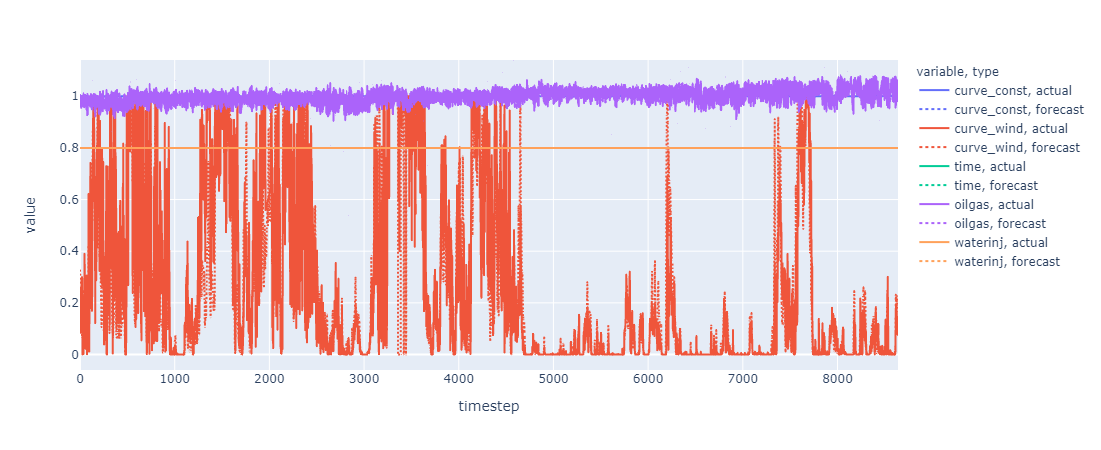

In [6]:
# View profiles (entire available time windows)
plots.plotProfiles(profiles,filename=None)

In [7]:
fuelA = data['paramDevice']['Gen1']['fuelA']
fuelB = data['paramDevice']['Gen1']['fuelB']
Pmax = data['paramDevice']['Gen1']['Pmax']
#plots.plotGasTurbineEfficiency(filename='gasturbine_Gen1.png',fuelA=fuelA,fuelB=fuelB,Pmax=Pmax)

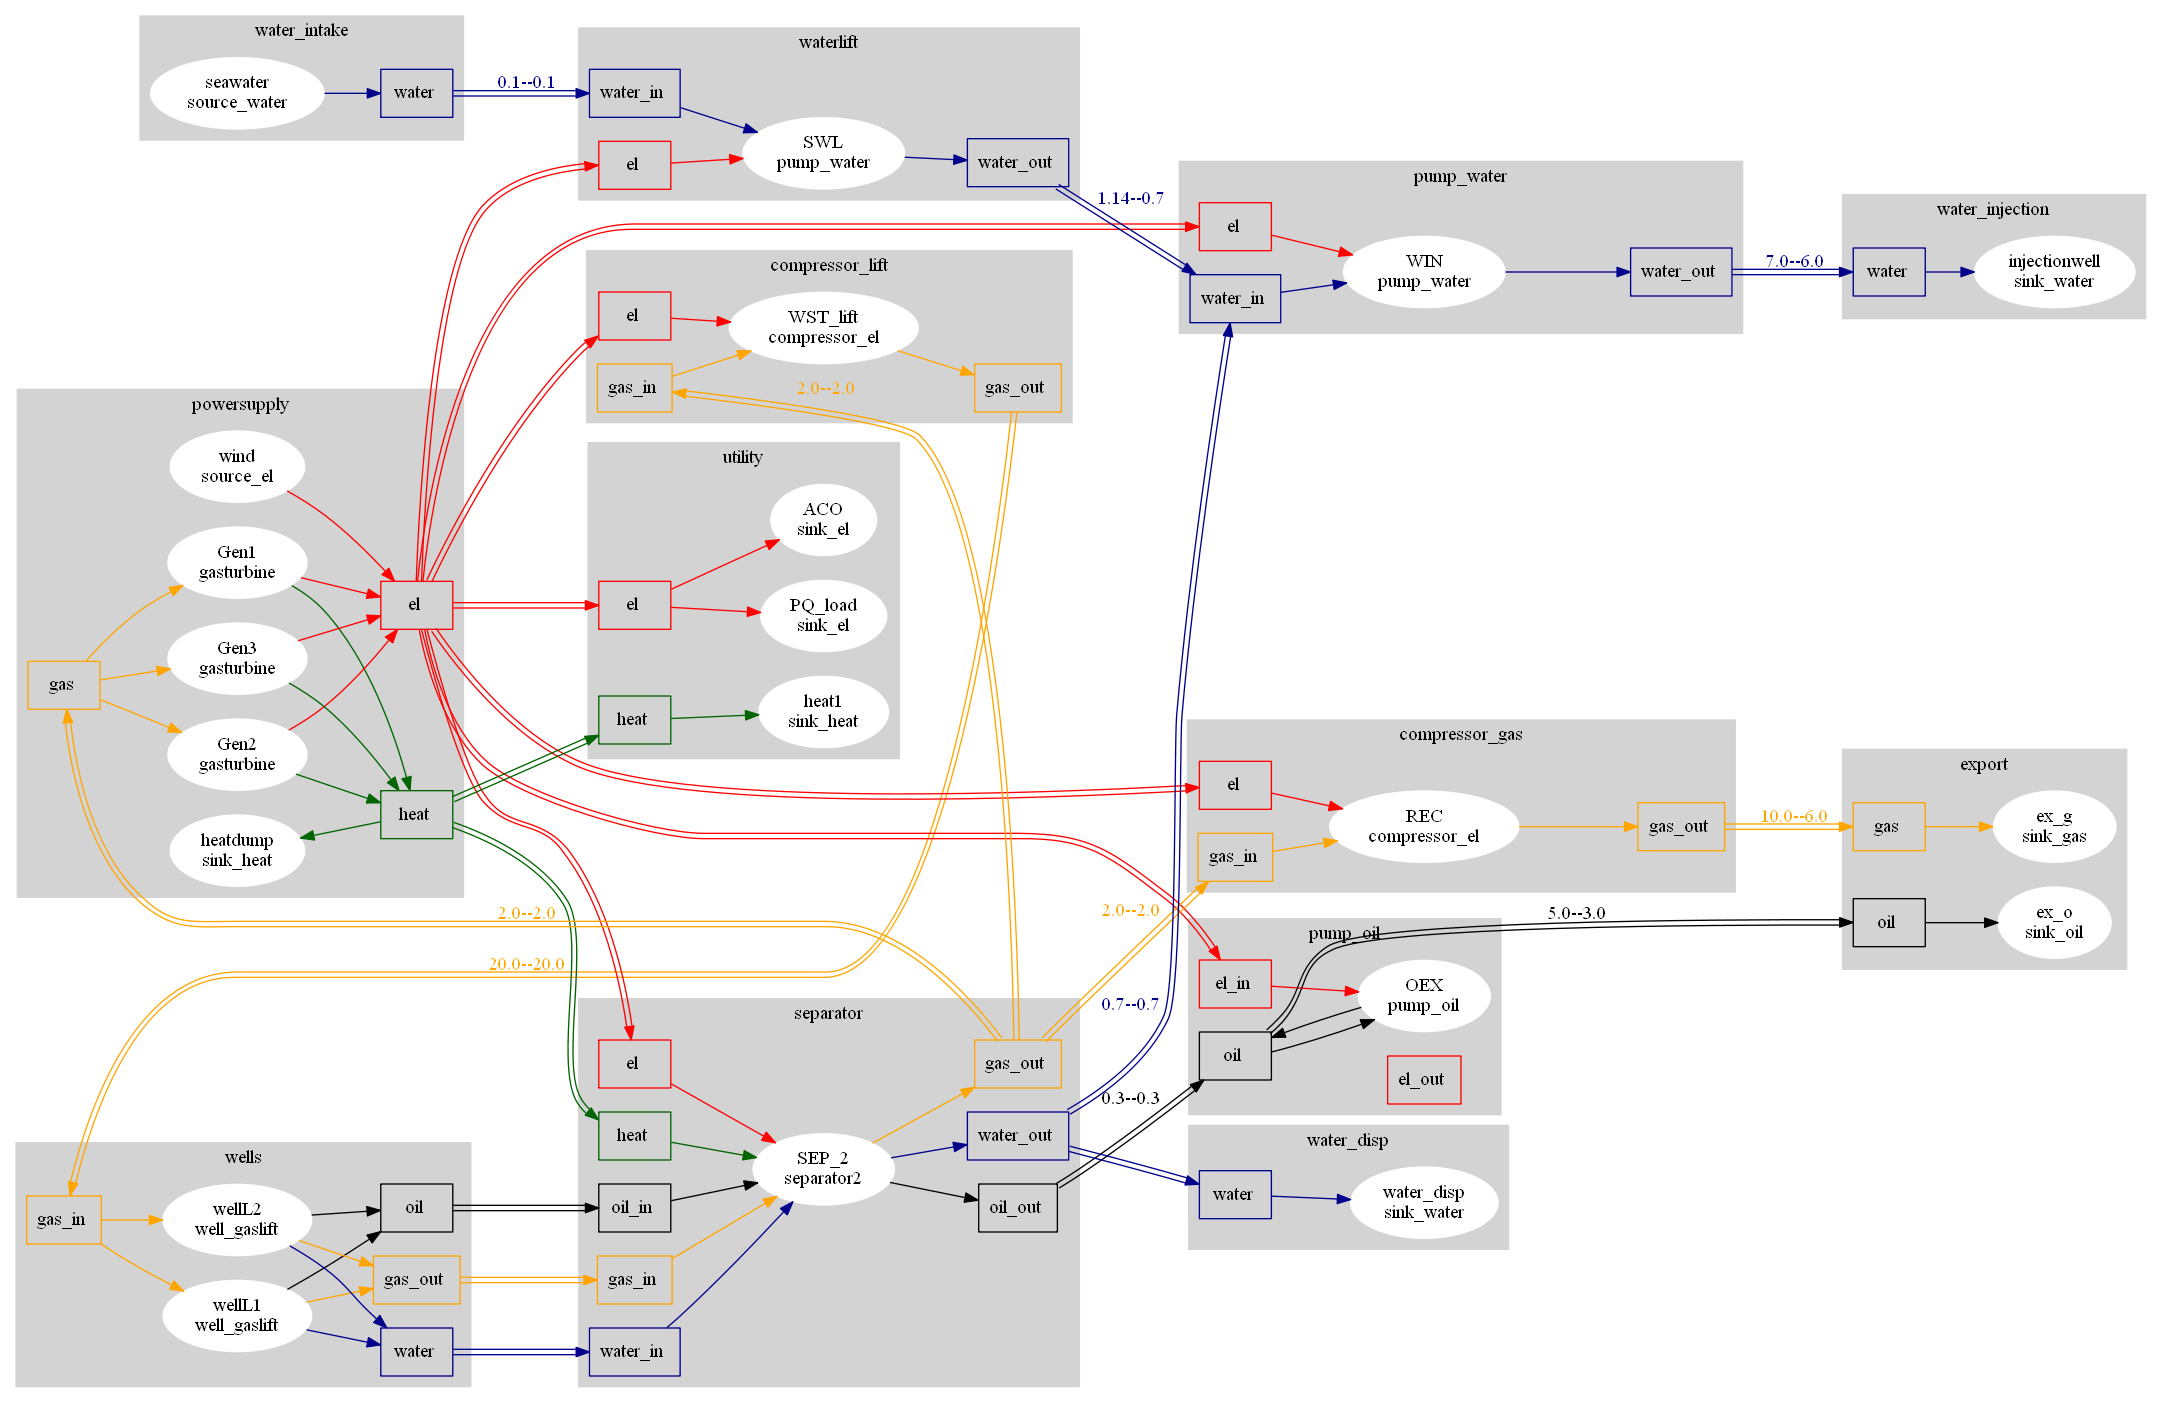

In [43]:
# View energy system
dotG=plots.plotNetwork(optimiser=optimiser,timestep=None,filename=None)
IPython.display.Image(dotG.create_png()) #scales automatically to page width

### Some checks on input data

In [9]:
print("flow per pipe = {:.4} Sm3/s".format(50/15))
flow1=oogeso.networks.network_edge.darcy_weissbach_Q(p1=6.164,p2=6,f=0.001,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow2=oogeso.networks.network_edge.darcy_weissbach_Q(p1=6.164,p2=4,f=0.0136,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow3=oogeso.networks.network_edge.darcy_weissbach_Q(p1=7,p2=4,f=0.0189,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
print("flow1 (6.164->6): {:.4}".format(flow1))
print("flow2 (6.164->4): {:.4}".format(flow2))
print("flow3 (7->4):     {:.4}".format(flow3))

flow per pipe = 3.333 Sm3/s
flow1 (6.164->6): 3.333
flow2 (6.164->4): 3.336
flow3 (7->4):     3.333


In [10]:
# Water pipe pressure drop ('w3')
#mc.instance.paramEdge['w3']['num_pipes']=15
#mc.instance.paramEdge['w1']['diameter_mm']=200
edge = optimiser.all_edges['w1']
print("Pressure out={:.4} MPa".format(edge.compute_edge_pressuredrop(
    optimiser.pyomo_instance,p1=1.14,Q=1.15/3,linear=False)))
print(edge.params)

Pressure out=0.6981 MPa
{'diameter_mm': 200.0, 'height_m': 40.0, 'include': 1, 'length_km': 0.01, 'nodeFrom': 'waterlift', 'nodeTo': 'pump_water', 'num_pipes': 3, 'pressure.from': 1.14, 'pressure.to': 0.7, 'type': 'water'}


## Solve

If the problem is infeasible, try 
* relaxing pressure deviation limits (generic value and per-node value)
* add a high cost emergency generator (that could represent load shedding) to ensure energy balance can be satisfied
* make sure excess heat/water/gas has a place to go


In [44]:
status = simulator.runSimulation(profiles=profiles,solver="cbc",timerange=timerange,write_yaml=False,timelimit=60)
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(simulator._dfCO2rate.mean()))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(simulator._dfCO2intensity.mean()))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in mc._dfExportRevenue.mean().items() if v!=0],"$/s")

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]WARNING:pyomo.core:Loading a SolverResults object with a warning status into model=unknown;
    message from solver=<undefined>
  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

    model=unknown;
        message from solver=<undefined>


Exception: Infeasible solution

In [28]:
optimiser.pyomo_instance.const

constr_Gen1_Pmax : Size=6, Index=setHorizon, Active=True
    Key : Lower : Body                                                      : Upper : Active
      0 :  -Inf : varDeviceFlow[Gen1,el,out,0] - 21.8*varDeviceIsOn[Gen1,0] :   0.0 :   True
      1 :  -Inf : varDeviceFlow[Gen1,el,out,1] - 21.8*varDeviceIsOn[Gen1,1] :   0.0 :   True
      2 :  -Inf : varDeviceFlow[Gen1,el,out,2] - 21.8*varDeviceIsOn[Gen1,2] :   0.0 :   True
      3 :  -Inf : varDeviceFlow[Gen1,el,out,3] - 21.8*varDeviceIsOn[Gen1,3] :   0.0 :   True
      4 :  -Inf : varDeviceFlow[Gen1,el,out,4] - 21.8*varDeviceIsOn[Gen1,4] :   0.0 :   True
      5 :  -Inf : varDeviceFlow[Gen1,el,out,5] - 21.8*varDeviceIsOn[Gen1,5] :   0.0 :   True


## Save/Load simulation results
By saving to pickle file, it easy to later open and analyse the results without having to re-run the simulation

In [ ]:
# Save (pickle) - for later opening and analysis
with open(pickle_save, mode='wb') as file:
   cloudpickle.dump(mc, file)
print("Results were saved to {}".format(pickle_save))

In [ ]:
# Open previously saved object (including simulation results)
#with open(pickle_save, mode='rb') as file:
#   mc = cloudpickle.load(file)

## Analyse results

In [ ]:
kpi = mc.compute_kpis(windturbines=['wind'])
kpi = pd.DataFrame.from_dict(kpi,orient="index",columns=[case])
kpi

In [ ]:
tstep=16
gCombined = plots.plotNetwork(mc,timestep=tstep,numberformat="{:.3g}",
    filename=outpath+"network_combined.png")
IPython.display.Image(gCombined.create_png())

In [ ]:
print("CHECKING edge pressure drop on selected edges:")
print('w1: {:.5g} MPa'.format(oogeso.milp_compute.compute_edge_pressuredrop(mc.instance,edge='w1',Q=1.15,p1=0.7,linear=True)))
print('w3: {:.5g} MPa'.format(oogeso.milp_compute.compute_edge_pressuredrop(mc.instance,edge='w3',Q=1.3/15,p1=7,linear=False)))
print('o2: {:.5g} MPa'.format(oogeso.milp_compute.compute_edge_pressuredrop(mc.instance,edge='o2',Q=0.1,p1=5,linear=True)))
print('g2: {:.5g} MPa'.format(oogeso.milp_compute.compute_edge_pressuredrop(mc.instance,edge='g2',Q=48,p1=10,linear=True)))

In [ ]:
mc.checkEdgePressureDrop(timestep=1,var="outer")

In [ ]:
plots.plotter='plotly'
fig2=plots.plot_SumPowerMix(mc,carrier="el",filename=None)
fig2.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=0,b=0))
#fig2.write_image("{}/elpowermix_{}.png".format(outpath,case))

In [ ]:
mean_el_demand = mc._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_heat_demand = mc._dfDeviceFlow.unstack('carrier')['heat'].unstack('terminal')['in'].dropna().unstack().T.mean()
energydemand = pd.concat({'el':mean_el_demand,'heat':mean_heat_demand},axis=1)
energydemand.drop('heatdump',inplace=True)
energydemand.plot.barh(title="Mean power demand (MW)")
energydemand

In [ ]:
print("Gas flow out ot terminal:")
mc._dfDeviceFlow.unstack('carrier')['gas'].unstack('terminal')['out'].dropna().unstack().T.mean()

In [ ]:
well_inout=mc._dfDeviceFlow.unstack('device')[['wellL1','wellL2']].sum(axis=1).unstack('time').mean(axis=1).unstack('terminal')
print("Net gas production = {:.5g} Sm3/s".format((well_inout['out']-well_inout['in']).sum()))
print("Gas circulated =     {:.5g} Sm3/s".format(well_inout['in'].sum()))

In [ ]:
# Check DUALS ()
# display all duals
for c in instance.component_objects(pyo.Constraint, active=True):
    if len(c)>0:
        print ("   Constraint",c, (len(c)))
        ci=list(c)[0:6]
        for index in ci:
            thedual=instance.dual[c[index]]
            if thedual!=0:
                print ("      ", index, thedual)

In [ ]:
plots.plotter="plotly"
gts = [d for d in mc.instance.setDevice 
       if mc.instance.paramDevice[d]['model']=='gasturbine']
fig=plots.plot_deviceprofile(mc,devs=gts,filename=None,includeOnOff=True,includePrep=True)
fig.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=30,b=0))

In [ ]:
# Print constraint for last rolling horizon optimisation
gt='Gen2'
print("GT is on initially ={}".format(pyo.value(mc.instance.paramDeviceIsOnInitially[gt])))
print("GT timesteps in startup preparation = {}".format(pyo.value(mc.instance.paramDevicePrepTimestepsInitially[gt])))
for t in range(6):
    cstr=mc.instance.constrDevice_startup_shutdown[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))

In [ ]:
dfStartopt = pd.DataFrame()
for t in mc.instance.setHorizon: 
    dfStartopt.loc[t,'start']=mc.instance.varDeviceStarting['Gen2',t].value
    dfStartopt.loc[t,'prep']=mc.instance.varDeviceIsPrep['Gen2',t].value
    dfStartopt.loc[t,'on']=mc.instance.varDeviceIsOn['Gen2',t].value
    dfStartopt.loc[t,'stop']=mc.instance.varDeviceStopping['Gen2',t].value
#dfStartopt

In [ ]:
plots.plotter='plotly'
#plots.plotter='matplotlib'

In [ ]:
fig=plots.plot_deviceprofile(mc,devs=['wind'],filename=None,includeForecasts=True)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [ ]:
df=mc._dfDeviceFlow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
df.columns=['gas','oil']
df=df.reset_index()
df = df.melt(var_name="Product",value_name="Volume rate (Sm3/s)",id_vars=('time'))
px.line(df,x="time",y="Volume rate (Sm3/s)",color="Product",title="Oil/gas export volumes (Sm3/s)").show()

plots.plot_ExportRevenue(mc)

In [ ]:
plots.plotter="plotly"
fig=plots.plot_deviceprofile(mc,devs=['wind'],includeForecasts=True,includeOnOff=False,
                             filename=None)#outpath+"WT_opt.png")
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),width=800,height=300)
fig.show()

In [ ]:
plots.plotter="plotly"
if 'battery' in mc.instance.setDevice:
    fig=plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)#outpath+"battery_opt.png")
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
    oogeso.milp_plot.plotDevicePowerLastOptimisation1(mc,device='battery',
                filename=None)#outpath+"lastopt_battery.png")

In [ ]:
plots.plotter="plotly"
fig=plots.plot_CO2rate_per_dev(mc,reverseLegend=True,filename=outpath+"co2rate_opt.png")
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [ ]:
fig=plots.plot_CO2_intensity(mc,filename=outpath+"co2intensity_opt.png")
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [ ]:
plots.plotReserve(mc,dynamicMargin=True)

In [ ]:
# This plot shows per device its output (dotted line) and the available online backup, iel reserve 
# by _other_ devices (solid line). MARGIN(t) = min_devices(backup(t) - output(t))
#plots.plotElBackup(mc,showMargin=True,returnMargin=False)